# ORIE 5355/INFO 5370 HW 2: Recommendation systems

In [ ]:
# clone the repository
!git clone https://github.com/tiffany85211/People-Data-Systems-Homework.git
%cd /content/People-Data-Systems-Homework/HW2


 - Name: Ting-Wei Chiang
 - Net-id: tc695
 - Date: 2021-09-27
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 0
 - People with whom you discussed this assignment: Yujie Shao (ys993), Ting-Wei Lu (tl574)

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/5AG69LXM4yV3TL7o6 and include the survey completion code below.

### Question 0 [2 points]
<font color='blue'> Survey completion code: hw22021abc

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

They run collarborative filtering on clients' ratings on different styles/clothings to fill in the missing elements in the sparse matrix, and to predict the result of sending a style to a client who has not yet received it.

To tackle the cold start problem, they use explicit client features from clients' self-descriptions of styles and explicit style features from clothing attributes. A new user or a new clothing might not have ratings/feedbacks/purchase histories, but they have these explicit data. 

Also, using structured and unstructured data of clients' feedback on different styles and their purchase histories, they can create latent factors for both clients and styles. These latent features can then be used in mixed-effects models (fixed effects + random effects) to learn and track clients' preferences over time.

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

First, they calculate a match score between each available stylist and each client who’s requested a shipment during the current period using data from fix history and feedback between that client and stylist (if any), and the affinities between the client's stated and latent style preferences and those of the stylist (style profile alignment). 

Then, they perform binary optimization to match each client with a stylist,  with the match scores as the cost matrix. Since there is a limited size of stylists' work queues, they are dealing with recommendations/matching with capacity constraints.  This is similar to solving maximum weight matching in a bipartite graph of clients and stylists, where the edge weights correspond to their match scores.

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

To anticipate future demand, they compute clients' states and their needs when in those different states, and then develop state transition matrices and Markov chain models. 

As for inventory management, they fit historical data to a model of the system dynamics, and use it for robust optimization given quantified uncertainties in their forecasts for purchase, allocation and clearance decisions. This way, they optimize the timing of purchase for different styles so that they maintain adequate inventory availability for stylists while minimizing the sum of ordering costs and carrying costs, the appropriate allocation of inventory to different warehouses, and what and when old inventory need to be donated to make room for new styles.



# Programming component

## Helper code

In [2]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'interaction'):
    ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return ratings, book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. 

Here, we work with multiple types of interactions as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 4 types of rating/interaction data:

 - `Interaction`: a "1" indicates the user has interacted with the book at some point in the past, either by saying that they intend to read it, have read it, or have given it a rating. If it is missing, that means the user has not interacted with the book.
 
 - `Explicit Rating`: explicit ratings. Numeric values indicate the ratings given. If it is missing, that means the user has not rated the book.
  
 - `Rating_all_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," so that there are no missing ratings.
 
 - `Rating_interaction_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," only if the user interacted with that book in the past.

In [3]:
ratings_interactions, book_vectors_interactions, user_vectors_interactions = load_ratings_and_factors(type_name = 'interaction')
ratings_explicit, book_vectors_explicit, user_vectors_explicit = load_ratings_and_factors(type_name = 'rating')
ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
ratings_interact0, book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')


In [4]:
def get_shapes_and_ranges(ratings, book_vectors, item_vectors):
    print(len(ratings), np.shape(book_vectors), np.shape(item_vectors), min(ratings.values()), max(ratings.values()))

In [5]:
get_shapes_and_ranges(ratings_interactions, book_vectors_interactions, user_vectors_interactions)
get_shapes_and_ranges(ratings_explicit, book_vectors_explicit, user_vectors_explicit)
get_shapes_and_ranges(ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(ratings_interact0, book_vectors_interact0, user_vectors_interact0)

12238 (200, 10) (1000, 10) 1 1
8324 (200, 10) (1000, 10) 1 5
200000 (200, 10) (1000, 10) 0 5
12238 (200, 10) (1000, 10) 0 5


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

`Rating_interaction_zero` tries to capture users' opinion to a book they have interacted with, and this can be ratings or a non-response. Just as the eBay paper assumed that "buyers who experience a bad or mediocre transaction are likely to be silent and not leave any feedback at all," here the metric `Rating_interaction_zero` assumes that readers who had a bad read are likely to not leave any ratings for that book, and therefore assigned rating 0s to the books a reader interacted with but did not rate.


<font color='blue'> What are some potential problems you see with using `rating_all_zero` for recommendations? Answer in no more than 3 sentences.
    
    

Instead of using matrix factorization to fill in the missing ratings, `Rating_all_zero` assumes that all users rated 0s (the worst) for all books they did not rate, most of which they didn't even interacted with. The recommendations from `rating_all_zero` may be biased towards popular and old/existing books as they have more interations, which means more non-zero ratings. Also, recommending a book that similar users rated 1 could potentially be worse than recommending a book that those users haven't read.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [6]:
def get_predictions(user_vectors, book_vectors):
    return np.matmul(user_vectors, book_vectors.T)

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 4 data types

In [7]:
interactions_pred = get_predictions(user_vectors_interactions, book_vectors_interactions)
print("Prediction - Interaction:\n", interactions_pred[0, :10])

explicit_pred = get_predictions(user_vectors_explicit, book_vectors_explicit)
print("Prediction - Explicit Rating:\n", explicit_pred[0, :10])

allmissing0_pred = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
print("Prediction - Rating_all_zero:\n", allmissing0_pred[0, :10])

interact0_pred = get_predictions(user_vectors_interact0, book_vectors_interact0)
print("Prediction - Rating_interaction_zero:\n", interact0_pred[0, :10])

Prediction - Interaction:
 [-0.00268685  0.01007861  0.00173543 -0.0009836   0.0029315   0.00733778
 -0.01030278  0.00722029  0.00110368  0.00335202]
Prediction - Explicit Rating:
 [ 0.07256422  0.40674721  0.07614967 -0.0750923   0.17636483  0.95914661
 -0.23892582 -0.00221766 -0.91204988  0.65839933]
Prediction - Rating_all_zero:
 [ 0.08031172  0.28975416  0.06345163  1.5695302  -0.18567229  0.05502522
  0.01107722 -0.08822294 -0.89503553 -0.01175208]
Prediction - Rating_interaction_zero:
 [-1.00879311  4.16663033 -0.91856862 -0.30194806 -2.52606751 -0.18905701
 -3.08103904 -0.53718459 -1.18618829 -1.21838417]


<font color='blue'> Do a scatterplot of the predicted rating for the "interaction" and "explicit ratings" types. (Each dot represents one user and one book, with X axis being predicted ratings using interaction data and Y axis being predicted rating using explicit ratings). Describe what you see in no more than 2 sentences. 

From the below plot, we can see that the predictions from the two data types have different ranges/scales, but show a weak to moderate positive correlation.

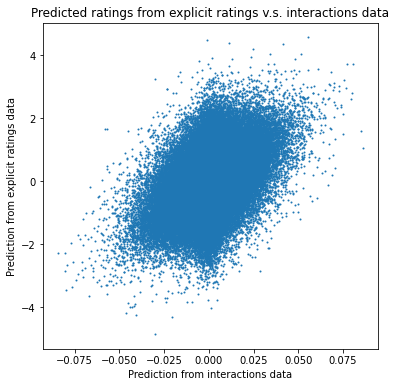

In [8]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(6,6))
plt.scatter(interactions_pred.flatten(), explicit_pred.flatten(), s=1)
plt.xlabel("Prediction from interactions data")
plt.ylabel("Prediction from explicit ratings data")
plt.title("Predicted ratings from explicit ratings v.s. interactions data")
plt.show()

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix predicted ratings for each user and item, returns a dictioanry where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [9]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    """ 
    returns a dictionary where the keys are User indices (= User ID - 1),
    and the values are a list of Item indices (= Item ID - 1) (length "number_top_items")
    indicating the recommendations given to that user
    """
    user_recommendations_dict = {}
    for i in range(predictions.shape[0]):
        user_recommendations_dict[i] = np.argsort(predictions[i])[-number_top_items:][::-1]
    return user_recommendations_dict

<font color='blue'> Output the recommendations for the first user, using each of the 4 data types

In [10]:
interactions_rec = get_recommendations_for_each_user(interactions_pred)
print("Top 10 Recommendations item index - Interaction:\n", interactions_rec[0])

explicit_rec = get_recommendations_for_each_user(explicit_pred)
print("Top 10 Recommendations item index - Explicit Rating:\n", explicit_rec[0])

allmissing0_rec = get_recommendations_for_each_user(allmissing0_pred)
print("Top 10 Recommendations item index - Rating_all_zero:\n", allmissing0_rec[0])

interact0_rec = get_recommendations_for_each_user(interact0_pred)
print("Top 10 Recommendations item index - Rating_interaction_zero:\n", interact0_rec[0])

Top 10 Recommendations item index - Interaction:
 [ 74 164 199  30  73 104 100  19 198 182]
Top 10 Recommendations item index - Explicit Rating:
 [ 30 164 121  87 199 116 108 124   5  93]
Top 10 Recommendations item index - Rating_all_zero:
 [57 55 56 81 50 78 58 86 77 96]
Top 10 Recommendations item index - Rating_interaction_zero:
 [166  53   1 111 170  74 182  37  73  52]


<font color='blue'> Fill in the following function that takes in the recommendations for each user and item, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [11]:
def show_frequency_histograms(recommendations):
    # counter dict {item_id: recommended_count}
    item_counter = {i: 0 for i in range(200)}
    for item in np.concatenate(list(recommendations.values())):
        item_counter[item] += 1
    # plot histogram
    fig = plt.subplots(figsize=(6,4))
    plt.hist(item_counter.values())
    plt.title("Histogram of how often each item is to be recommended")
    plt.ylabel('Items Count')
    plt.xlabel('Number of times appeared in top 10 recommendations')
    plt.show()
    return fig

<font color='blue'> Show the histograms for the "interact" and "explicit" data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

The histogram for the explicit data type is more evenly-distributed across the x-axis with 190 out of 200 items recommended at least once, whereas there is a peak at the first bar of the histogram for the interactions data type since 75 out of 200 items were never recommended. For the interactions data type, the most recommended items are recommended 298 times (i.e., appeared in Top 10 recommendations for 298 out of 1000 users), whereas the number is only 197 for the explicit data type. Therefore, using interactions data type would cause more trouble when dealing with recommendations with capacity constraints.

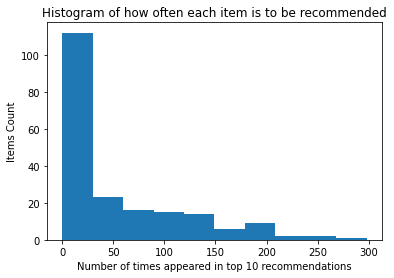

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f04bba8ef50>)

In [12]:
show_frequency_histograms(interactions_rec)

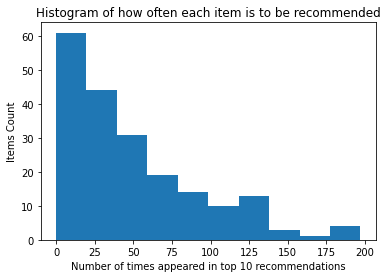

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f04bb95fa90>)

In [13]:
show_frequency_histograms(explicit_rec)

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [14]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the "ratings with interaction0" data.

In [15]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

In [16]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [17]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    median_wealth = existing_user_demographics.Wealth.median()
    if new_user.Wealth > median_wealth:
        existing_user_ids = existing_user_demographics[existing_user_demographics.Wealth > median_wealth]['User ID']
    else:
        existing_user_ids = existing_user_demographics[existing_user_demographics.Wealth <= median_wealth]['User ID']
    return existing_user_vectors[np.array(existing_user_ids) - 1].mean(axis=0)

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [18]:
get_user_vector_for_new_user(new_user_demographics.iloc[0], existing_user_demographics, existing_user_vectors)

array([ 0.08780943, -0.20709913, -0.17762736, -0.13094589, -0.08942902,
       -0.12702042, -0.12242308, -0.42681059, -0.05775285, -0.1056909 ])

### 2b) [Bonus, 3 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method. 
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [19]:
def encode_demographics(demographics):
    age_map = {'18 to 34': 0, '35 to 49': 1, '50 to 64': 2, '65 and older': 3}
    if type(demographics) == pd.Series:  # for testing
        demographics_encoded = demographics.drop(['User ID'])
        demographics_encoded['Age group'] = age_map[demographics_encoded['Age group']]
        for location in ['Africa', 'America', 'Asia Pacific', 'Europe']:
            if demographics_encoded['Location'] == location:
                demographics_encoded['Location_{}'.format(location)] = 1
            else:
                demographics_encoded['Location_{}'.format(location)] = 0
        demographics_encoded = demographics_encoded.drop(['Location'])
    else: # pd.DataFrame, for training
        # Drop User ID (not a feature)
        demographics_encoded = demographics.drop(columns=['User ID'])
        # Age: Ordinal mapping to 0-3
        demographics_encoded['Age group'] = demographics_encoded['Age group'].map(age_map)
        # Location: one-hot encoding 
        demographics_encoded = pd.get_dummies(demographics_encoded)
    return demographics_encoded

In [20]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(encode_demographics(existing_user_demographics))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [21]:
def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):
    nn = neigh.kneighbors(np.array(encode_demographics(new_user)).reshape(1, -1), return_distance=False).flatten()
    return existing_user_vectors[nn].mean(axis=0)

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [22]:
get_user_vector_for_new_user_knn(new_user_demographics.iloc[0], existing_user_demographics, existing_user_vectors)

array([ 0.70903393, -0.40304025, -0.01057082, -0.24033121,  0.53657061,
       -0.66545655, -0.49162102, -0.7764095 , -0.64347588, -0.40253368])

<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

I used K nearest neighbors and averaged the user vectors from their 3 nearest neighbors. The distance function is Euclidean Distance calculated from demographics data of Wealth (continuous variable), Age Group (ordinal variable from 0 to 3), and Location (one-hot encoding).

### 2c) Comparing predictions from from "true" user vector and from above

<font color='blue'> For each of the 100 "new" users, use either your model from 2a or 2b ("demographic model") to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. First, plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

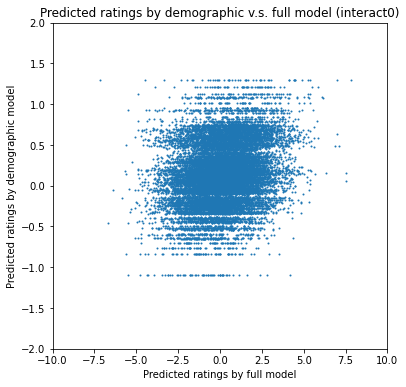

In [23]:
fig = plt.subplots(figsize=(6,6))
for idx, row in new_user_demographics.iterrows():
    new_user_vector = get_user_vector_for_new_user(row, existing_user_demographics, existing_user_vectors)
    new_pred = get_predictions(new_user_vector, book_vectors_interact0)
    full_pred = interact0_pred[idx]
    plt.scatter(full_pred, new_pred, s=1, c='tab:blue')
plt.xlim((-10, 10))
plt.ylim((-2, 2))
plt.xlabel("Predicted ratings by full model")
plt.ylabel("Predicted ratings by demographic model")
plt.title("Predicted ratings by demographic v.s. full model (interact0)")
plt.show()

<font color='blue'> Now for each user, calculate the mean rating (according to the "full" model in Problem 1) for the 10 items recommended to that user, by each of the demopgraphic and "full" models. Output a scatterplot for the two mean ratings, where each point correpsonds to 1 user. 

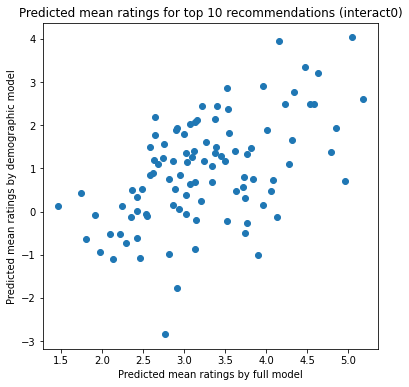

In [24]:
fig = plt.subplots(figsize=(6,6))

for user_ind, row in new_user_demographics.iterrows():
    new_user_vector = get_user_vector_for_new_user(row, existing_user_demographics, existing_user_vectors)
    new_pred = get_predictions(new_user_vector, book_vectors_interact0)
    new_rec_ind = get_recommendations_for_each_user(new_pred.reshape(1, -1))[0]
    full_rec_ind = interact0_rec[user_ind]
    new_pred_mean = interact0_pred[user_ind, new_rec_ind].mean()
    full_pred_mean = interact0_pred[user_ind, full_rec_ind].mean()
    plt.scatter(full_pred_mean, new_pred_mean, c='tab:blue')
plt.xlabel("Predicted mean ratings by full model")
plt.ylabel("Predicted mean ratings by demographic model")
plt.title("Predicted mean ratings for top 10 recommendations (interact0)")
plt.show()

<font color='blue'> Comment on the above. What is the "loss" from using demogprahics since we do not have access to the full data?

The first scatter plot is in a flat shape, showing that the predicted ratings from the simple demographic model (using the median of Wealth score) are compacted in a smaller range of (-1.5, 1.5). This indicates that the predicted rating scores across the 200 items are more similar and homogeneous, so it's harder to distinguish good items from bad ones to recommend using the demographics model. 

The second scatter plot also shows the limitations of using demographics for recommendations. Although there is a correlation found between the mean predicated ratings (according to the "full" model) from top 10 recommendations from the demographics model and from the full model, those numbers from the demographics model are not as high, with plenty of users getting a mean value below zero.

Using demographics to predict ratings for new users assume that their preferences and behaviors are similar to those who share similar demographics such as wealth, location, and age. For examples, in the case of 2(a), we categorized people to two big groups and give each group the same recommendations. However, the taste for books can be very personal and unique, and we lost these information if we don't have their historical data.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

In [25]:
item_n = len(book_vectors_interact0)
user_n = len(user_vectors_interact0)

def get_recommendation_rank_with_capacity_constraints(pred, use_score_function=False):
    pred = pred.copy()
    item_counter = np.array([5] * item_n)
    user_rec_rank_list = []
    interact0_rec_all = get_recommendations_for_each_user(pred, number_top_items=item_n)
    if use_score_function:
        # Normalize prediction score to (0, 1)
        min_max_range = pred.max(axis=0) - pred.min(axis=0)
        pred -= pred.min(axis=0)
        pred /= min_max_range
        pred /= pred.mean(axis=0)
    for user_ind in range(user_n):
        if use_score_function:
            rec = np.argsort(pred[user_ind] * (item_counter ** 0.5))[::-1]
        else:
            rec = interact0_rec_all[user_ind]
        for rec_rank, item_ind in enumerate(rec):
            if item_counter[item_ind] > 0:
                item_counter[item_ind] -= 1
                if use_score_function:
                    user_rec_rank_list.append(list(interact0_rec_all[user_ind]).index(item_ind) + 1)
                else: 
                    user_rec_rank_list.append(rec_rank + 1)
                break
    assert sum(item_counter) == 0
    return user_rec_rank_list

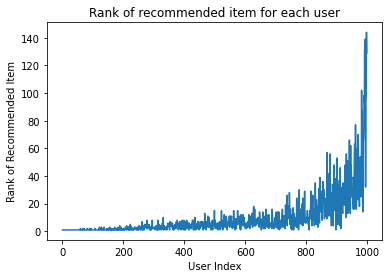

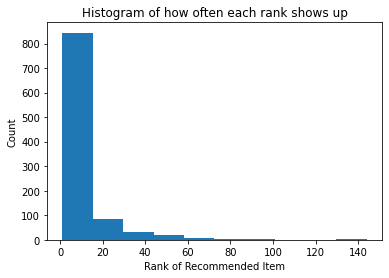

In [26]:
def plot_line_rec_item_rank_for_each_user(user_rec_rank_list):
    fig = plt.subplots(figsize=(6,4))
    plt.plot(user_rec_rank_list)
    plt.xlabel("User Index")
    plt.ylabel("Rank of Recommended Item")
    plt.title("Rank of recommended item for each user")
    plt.show()

def plot_hist_rec_item_rank(user_rec_rank_list):
    fig = plt.subplots(figsize=(6,4))
    plt.hist(user_rec_rank_list)
    plt.xlabel("Rank of Recommended Item")
    plt.ylabel("Count")
    plt.title("Histogram of how often each rank shows up")
    plt.show()

user_rec_rank_list_naive = get_recommendation_rank_with_capacity_constraints(interact0_pred)
plot_line_rec_item_rank_for_each_user(user_rec_rank_list_naive)
plot_hist_rec_item_rank(user_rec_rank_list_naive)

### 3b) [Bonus -- 6 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[3 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

Compared to the naive recommendations, the histogram remains similar and highly right-skewed, showing that most recommendations given are on the top list of users' predicted ratings. 

However, the line plot for naive method shows that the users that come in earlier have the advantage since they don't suffer from capacity constraints. Maximum weight matching solved this probelm as all users, regardlessness of the their index, have a more equal opportunity to be matched with items on their top list. For the line plot for maximum weight matching, it is more evenly distributed among the 1000 users, without a clear trend going upwards.

In [27]:
def get_recommendation_rank_from_item_list(item_ind_list):
    interact0_rec_all = get_recommendations_for_each_user(interact0_pred, number_top_items=item_n)
    user_rec_rank_list = []
    for user_ind in range(user_n):
        user_rec_rank_list.append(list(interact0_rec_all[user_ind]).index(item_ind_list[user_ind]) + 1)
    return user_rec_rank_list

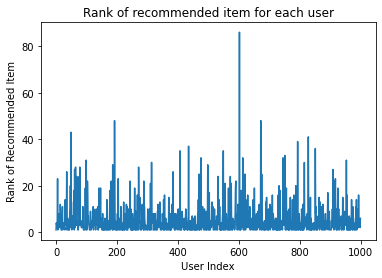

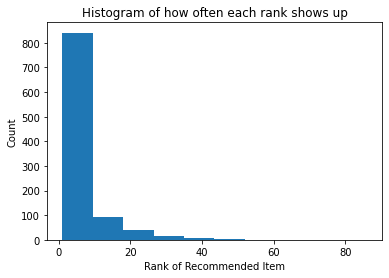

In [28]:
from scipy.optimize import linear_sum_assignment

def maximum_weight_matching(pred):
    cost = np.tile(pred, 5)
    row_ind, col_ind = linear_sum_assignment(cost, maximize=True)
    return col_ind % 200

rec_item_list = maximum_weight_matching(interact0_pred)
user_rec_rank_list_maxweightmatching = get_recommendation_rank_from_item_list(rec_item_list)
plot_line_rec_item_rank_for_each_user(user_rec_rank_list_maxweightmatching)
plot_hist_rec_item_rank(user_rec_rank_list_maxweightmatching)

[3 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

The histogram for batched maximum weight matching remains similar to those from naive method and maximum weight matching as it is highly right-skewed, indicating that the recommendations are concentrated on top rankings.

The line plot for batched maximum weight matching is in between that from the naive method and that from maximum weight matching. The disparity between early-coming users and late-coming users are not as extreme, as the largest rank number is 94, compared to 144 from naive method. However, later batches of users still suffer from capacity constraints, as batched maximum weight matching can only optimize matching for each batch of users, and fails to allocate resources for future-coming users.

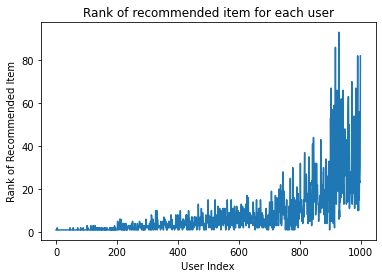

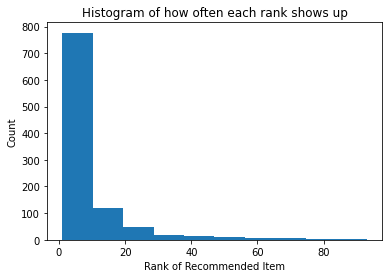

In [29]:
def batched_maximum_weight_matching(pred):
    item_counter = np.array([5] * item_n)
    all_col_ind = []
    for batch_n in range(int(user_n/100)):
        cost = np.repeat(pred[(100*batch_n):(100*(batch_n+1))], item_counter, axis=1)
        row_ind, col_ind = linear_sum_assignment(cost, maximize=True)
        item_ind = []
        for c in col_ind:
            item_ind.append(np.argwhere(item_counter.cumsum() > c)[0][0])
        all_col_ind.extend(item_ind)
        for i in item_ind:
            if item_counter[i] > 0:
                item_counter[i] -= 1
    return all_col_ind

rec_item_list = batched_maximum_weight_matching(interact0_pred)
user_rec_rank_list_maxweightmatching_batch = get_recommendation_rank_from_item_list(rec_item_list)
plot_line_rec_item_rank_for_each_user(user_rec_rank_list_maxweightmatching_batch)
plot_hist_rec_item_rank(user_rec_rank_list_maxweightmatching_batch)

### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3c, show the same two plots, and describe what you observe.

For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{ij}}} \sqrt{C_j} $$

From the histogram, we can see that the recommendation system using score functions is doing a better job than the above methods as most recommendations are in the first bar of the histogram (top rankings).

By using score functions, we can still solve the problem for capacity constraints without the downsides of naive method or maximum weight matching. Unlike naive method, there is not a clear upward trend in the line plot, showing that there is not a big difference between early-coming and late-coming users. Most users got a prediction under rank number 50, regardless of their order in the list. Also, it can be run sequentially. It does not assume all users come at once, or have to wait till batching could happen so we can solve the optimization problem of maximum weight matching.

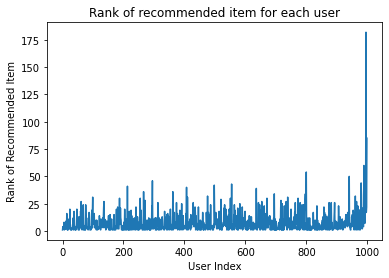

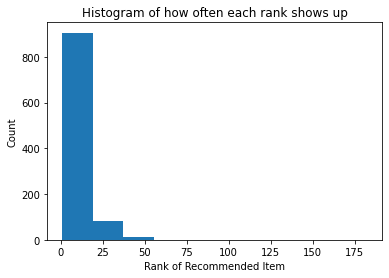

In [30]:
user_rec_rank_list_score = get_recommendation_rank_with_capacity_constraints(interact0_pred, use_score_function=True)
plot_line_rec_item_rank_for_each_user(user_rec_rank_list_score)
plot_hist_rec_item_rank(user_rec_rank_list_score)

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 

In [32]:
!sudo wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('HW2_assignment.ipynb')

--2021-10-06 01:50:09--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2021-10-06 01:50:09 (29.4 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HW2_assignment.ipynb to pdf
[NbConvertApp] Support files will be in HW2_assignment_files/
[NbConvertApp] Making directory ./HW2_assignment_files
[NbConvertApp] Making directory ./HW2_assignment_files
[NbConvertApp] Making directory ./HW2_assignment_files
[NbConvertApp] Making di

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'